### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from pandas import read_csv

In [3]:
import tensorflow as tf

# Define the dataset path
dataset_path = '/content/drive/MyDrive/Data/archive (1)/Leaves'

# Load the dataset
try:
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        shuffle=True,
        image_size=(255, 255),
        batch_size=32
    )
    # Verify the loaded dataset
    for images, labels in dataset.take(1):
        print(images.shape, labels.shape)
except Exception as e:
    print(f"Error loading dataset: {e}")


Found 607 files belonging to 5 classes.
(32, 255, 255, 3) (32,)


## DATA CLEANING AND PREPROCESSING

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Data/archive (1)/Leaves",shuffle =True,image_size = (255, 255), batch_size = 32)

Found 607 files belonging to 5 classes.


### CHECKING CLASSES PRESENT IN DATASET

In [5]:
dataset.class_names

['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

## Count of Images

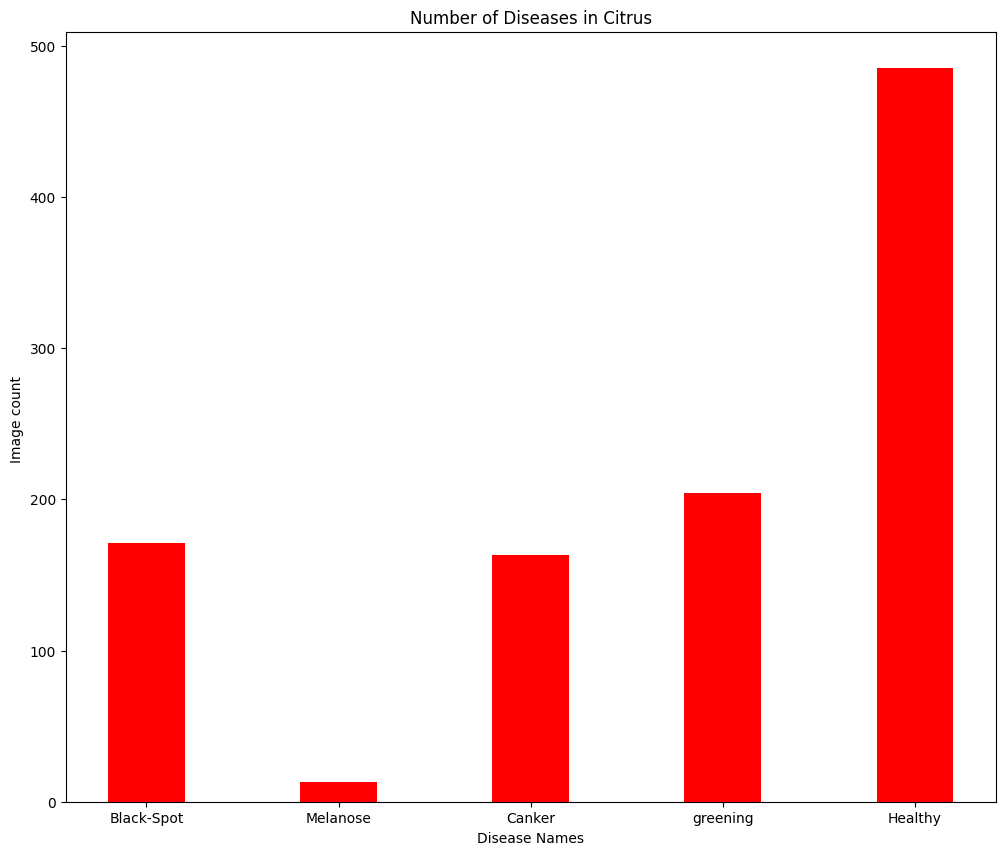

In [6]:
data = {'Black-Spot':171, 'Melanose':13, 'Canker':163,
        'greening':204,'Healthy':485}
Labels = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (12, 10))
plt.bar(Labels, values, color ='red',
        width = 0.4)
plt.xlabel("Disease Names")
plt.ylabel("Image count ")
plt.title("Number of Diseases in Citrus")
plt.show();

### PLOTTING THE IMAGES

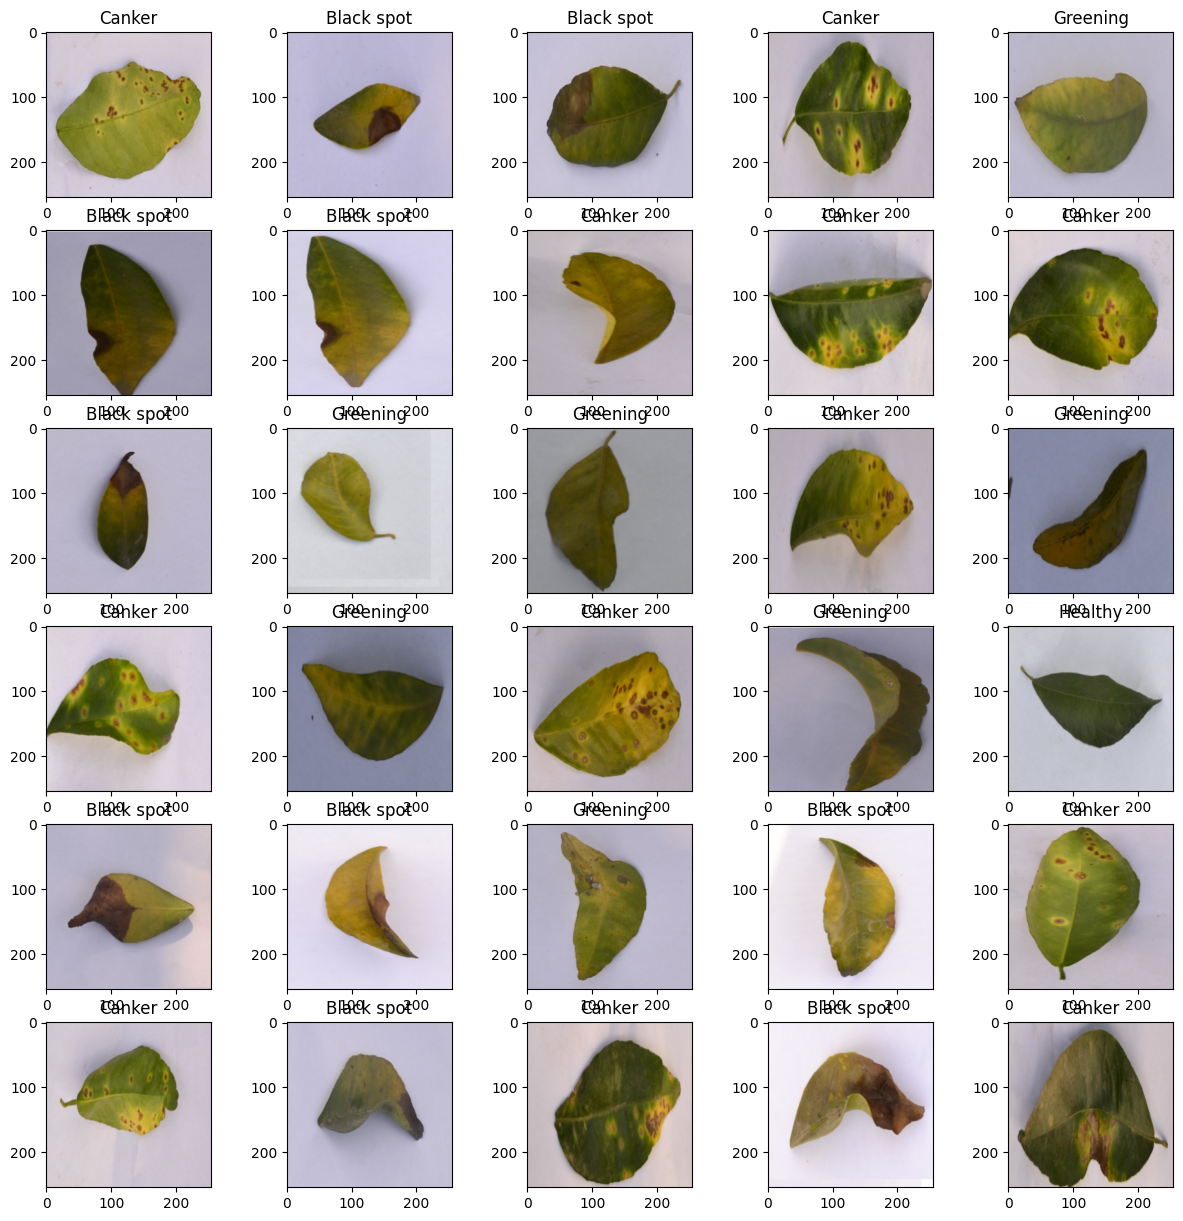

In [7]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(30):
    ax = plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[label_batch[i]])
    plt.axis("ON")

### DEFINING DATA FOR TRAINING, TESTING AND VALIDATION

In [8]:
def partition_of_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=10)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = partition_of_data(dataset)

In [10]:
print("Batches of training data :- ",len(train_ds))

Batches of training data :-  15


In [11]:
print("Batches of validation data :- ",len(val_ds))

Batches of validation data :-  1


In [12]:
print("Batches of testing data :- ",len(test_ds))

Batches of testing data :-  3


### MODEL BUILDING

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(255, 255),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32, 255, 255, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax'),
])


In [16]:
model.build(input_shape=(32, 255, 255, 3))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',patience=10,
    mode="max"
)

In [20]:
hist = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,callbacks=early_stopping,
    epochs=2,verbose=1
)

Epoch 1/2
15/15 [==============================] - 110s 4s/step - loss: 1.5259 - accuracy: 0.2839 - val_loss: 1.4915 - val_accuracy: 0.1875
Epoch 2/2
15/15 [==============================] - 67s 4s/step - loss: 1.3526 - accuracy: 0.2797 - val_loss: 1.2287 - val_accuracy: 0.4062


## MODEL EVALUATION

In [21]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 7s 981ms/step - loss: 1.2637 - accuracy: 0.3333


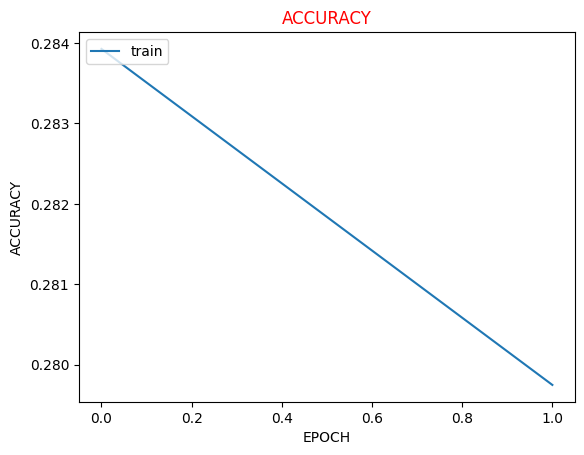

In [22]:
# accuracy of the model
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.title("ACCURACY",color="red")
plt.ylabel("ACCURACY")
plt.xlabel("EPOCH")
plt.legend(['train'],loc='upper left')
plt.show()

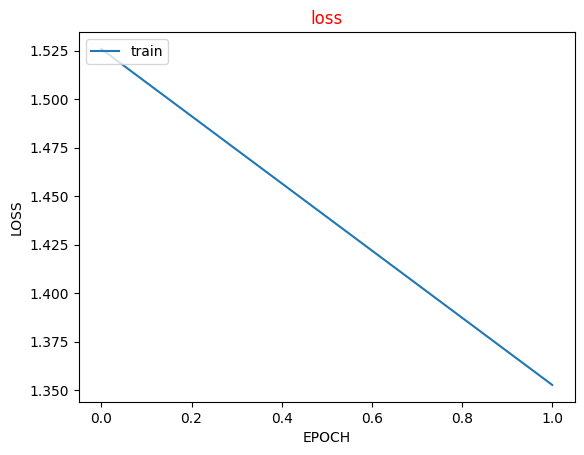

In [23]:
# loss of the model
plt.plot(hist.history['loss'])
plt.title("loss",color="red")
plt.ylabel("LOSS")
plt.xlabel("EPOCH")
plt.legend(['train'],loc='upper left')
plt.show()

In [24]:
# Prediction of first 10 labels in testing data
y_pre=model.predict(test_ds)
y_class=[np.argmax(i) for i in y_pre]
# print("Predicted Classes :-",y_class[:10])
ls=[]
for i in y_class[:10]:
    if i==0:
        ls.append("Back Spot")
    elif i==1:
        ls.append("Canker")
    elif i==2:
        ls.append("Greening")
    elif i==3:
        ls.append("Healthy")
    else:
        ls.append("Mealnose")
print("Predicted Classes :-\n",ls)

3/3 [==============================] - 7s 922ms/step
Predicted Classes :-
 ['Greening', 'Greening', 'Greening', 'Greening', 'Greening', 'Greening', 'Greening', 'Greening', 'Greening', 'Greening']


First image of batch to predict :
Actual label :  Canker
1/1 [==============================] - 1s 1s/step
Predicted label :  Greening


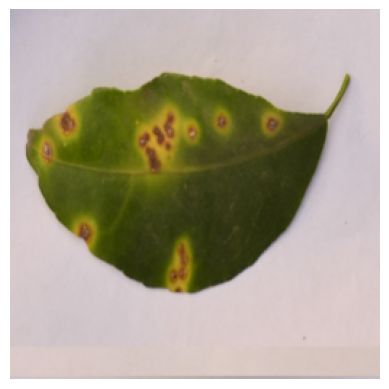

In [25]:
for batch_image, batch_label in train_ds.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = dataset.class_names[batch_label[0]]

    print('First image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)

    batch_prediction = model.predict(batch_image)
    prediction = dataset.class_names[np.argmax(batch_prediction[0])]
    print('Predicted label : ', prediction)
    plt.axis('off')




In [26]:
# Evaluate the model on the validation dataset
val_loss, val_acc = model.evaluate(test_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

3/3 [==============================] - 8s 926ms/step - loss: 1.2812 - accuracy: 0.3438
Validation loss: 1.2811511754989624
Validation accuracy: 0.34375


In [28]:
from sklearn.metrics import confusion_matrix , classification_report
target_names= ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

# Get true labels for the entire test dataset
y_true = [] # Initialize as empty list
for images, labels in test_ds:
    y_true.extend(labels.numpy()) # Append integer labels

# Get predicted labels for the entire test dataset
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure both lists have the same length by truncating the longer one
min_length = min(len(y_true), len(y_pred))
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]

# Convert numerical labels to class names
y_true_names = [dataset.class_names[i] for i in y_true] # Now y_true contains only integers
y_pred_names = [dataset.class_names[i] for i in y_pred]

report = classification_report(y_true_names, y_pred_names, target_names = target_names)
print(report)

3/3 [==============================] - 6s 932ms/step
              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00        23
      Canker       0.00      0.00      0.00        20
    Greening       0.43      1.00      0.60        41
     Healthy       0.00      0.00      0.00         8
    Melanose       0.00      0.00      0.00         4

    accuracy                           0.43        96
   macro avg       0.09      0.20      0.12        96
weighted avg       0.18      0.43      0.26        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
from sklearn.metrics import confusion_matrix , classification_report
# Assuming 'model' is your trained DenseNet201 model and 'test_ds' is your validation dataset
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1) # Get predicted labels
target_names = [f"{dataset.class_names[i]}" for i in range(len(dataset.class_names))] # Use dataset.class_names if available
print(classification_report(y_true, y_pred, target_names=target_names)) # Assuming y_true contains the true labels for the validation set

3/3 [==============================] - 5s 929ms/step
              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00        23
      Canker       0.00      0.00      0.00        20
    Greening       0.43      1.00      0.60        41
     Healthy       0.00      0.00      0.00         8
    Melanose       0.00      0.00      0.00         4

    accuracy                           0.43        96
   macro avg       0.09      0.20      0.12        96
weighted avg       0.18      0.43      0.26        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 607 files belonging to 5 classes.
Using 486 files for training.
Found 607 files belonging to 5 classes.
Using 121 files for validation.
Epoch 1/10
16/16 [==============================] - 82s 5s/step - loss: 105.2235 - accuracy: 0.3107 - val_loss: 1.5117 - val_accuracy: 0.3636
Epoch 2/10
16/16 [==============================] - 72s 4s/step - loss: 1.3142 - accuracy: 0.4650 - val_loss: 1.5341 - val_accuracy: 0.4298
Epoch 3/10
16/16 [==============================] - 66s 4s/step - loss: 1.3562 - accuracy: 0.5761 - val_loss: 1.0150 - val_accuracy: 0.5207
Epoch 4/10
16/16 [==============================] - 62s 4s/step - loss: 1.2129 - accuracy: 0.5247 - val_loss: 1.3297 - val_accuracy: 0.3967
Epoch 5/10
16/16 [==============================] - 68s 4s/step - loss: 0.8296 - accuracy: 0.6770 - val_loss: 1.1016 - val_accuracy: 0.6198
Epoch 6/10
16/16 [==============================] - 63s 4s/step - loss: 0.4585 - accuracy: 0.8251 - val_loss: 1.3858 - val_accuracy: 0.5207
Epoch 7/10
16/16

FileUpload(value={}, accept='image/*', description='Upload')

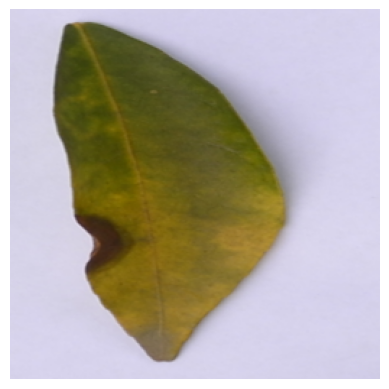

1/1 [==============================] - 0s 126ms/step
The plant is: Black spot


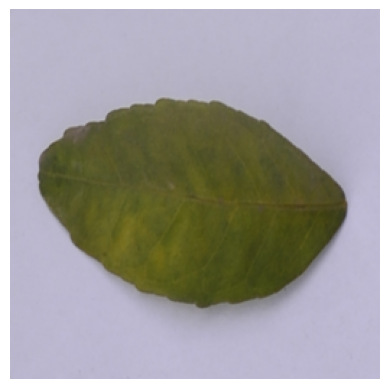

1/1 [==============================] - 0s 80ms/step
The plant is: Greening


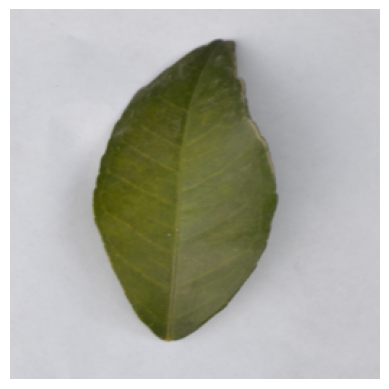

1/1 [==============================] - 0s 53ms/step
The plant is: Healthy


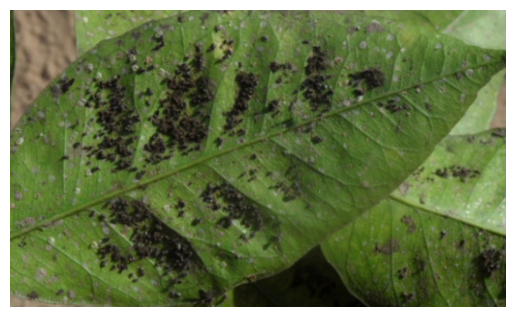

1/1 [==============================] - 0s 56ms/step
The plant is: Melanose


In [34]:
# Step 1: Install Necessary Libraries
!pip install tensorflow pillow ipywidgets

# Step 2: Import Necessary Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import io
from PIL import Image

# Step 3: Load and Preprocess Dataset (replace with your dataset directory)
dataset_dir = '/content/drive/MyDrive/Data/archive (1)/Leaves'  # Replace with your dataset path
batch_size = 32
img_size = (224, 224)

# Load dataset and get class names
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names

# Preprocess function
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

# Map preprocess function to datasets
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

# Step 4: Define and Train the Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=10)

# Step 5: Save and Load the Model
model.save("citrus_model.h5")
model = tf.keras.models.load_model("citrus_model.h5")

# Step 6: Function to Detect Disease from Uploaded Image
def detect_disease(img):
    img = img.resize(img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)

    result = class_names[predicted_label]
    print(f"The plant is: {result}")

# Step 7: Create an Upload Button
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    # Extract the uploaded image content
    file_info = next(iter(upload_button.value.values()))
    img = Image.open(io.BytesIO(file_info['content']))

    # Display the uploaded image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Predict the disease
    detect_disease(img)

upload_button.observe(on_upload_change, names='value')
display(upload_button)
